# Natural Language Email Classification

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# LOAD DATA
df = pd.read_csv('../../data/glic-emails-v14.tsv', sep='\t')
df.head()

,Category,EmailContent
0,secure,You have received a secure message
1,secure,Read your secure message by opening the attach...
2,secure,You have received an email message secured by ...
3,secure,Password is Summer26. Please let me know if yo...
4,secure,This is a secure encrypted message. To view th...


## Check the Quality of data for training

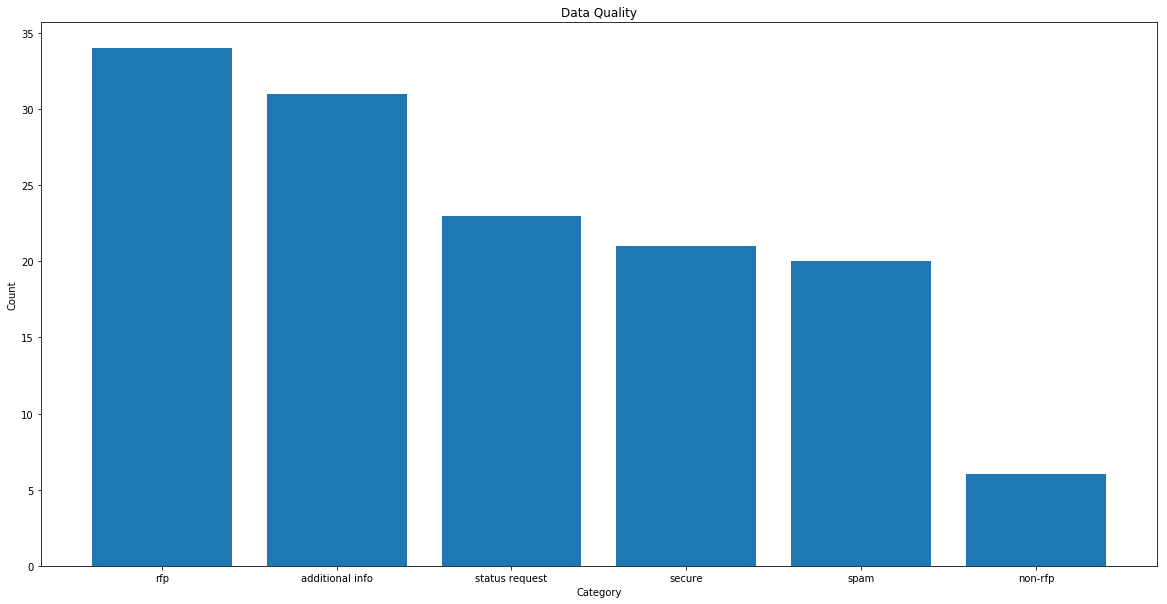

In [3]:
df_quality_counts = df['Category'].value_counts().head(10)
plt.figure(figsize=(20,10))
plt.title("Data Quality")
# plt.ylim()
plt.xlabel("Category")
plt.ylabel("Count")
plt.bar(df_quality_counts.keys(), df_quality_counts.values)
plt.show()  

## Using Tensorflow and Keras for Classification

In [4]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding

print(tf.__version__)

Using TensorFlow backend.


1.9.0


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df["EmailContent"].values)

X = tokenizer.texts_to_sequences(df["EmailContent"].values)
X = pad_sequences(X, maxlen=50)
categories = df["Category"].unique()
categories = sorted(list(set(categories)))
output_empty = [0] * len(categories)
Y = []
for i in range( 0, len(X)):
    output_row = list(output_empty)
    category = df["Category"][i]
    output_row[categories.index(category)] = 1
    Y.append(output_row)

print("Length of X: >> ", len(X))
print("Length of Y: >> ", len(Y))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

Length of X: >>  135
Length of Y: >>  135


In [6]:
CONFIG = {
  "MODEL_PATH": "results/model/",
  "model_name": "EmailClassification_Model.h5",
  "model_weights": "EmailClassification_Model_weights.hdf5",
  "log_dir": "tensorboard_logs",
  "epochs": 200,
  "batch_size": 32,
  "activation": "softmax",
  "loss": "binary_crossentropy",
  "optimizer": "adam",
  "metrics": ["accuracy"],
  "patience": 20
}

if not os.path.exists(CONFIG["MODEL_PATH"]):
    os.makedirs(CONFIG["MODEL_PATH"], exist_ok=True)

In [7]:
from keras import backend as K
from keras.models import load_model
K.clear_session()
tf.reset_default_graph()
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
    embedding_vector_length = 32

    model = Sequential()
    model.add(Embedding(500, embedding_vector_length, input_length=50))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(len(Y_train[0]), activation=CONFIG["activation"]))
    model.compile(loss=CONFIG["loss"], optimizer=CONFIG["optimizer"], metrics=CONFIG["metrics"])
    print(model.summary())

    tbCallBack = tf.keras.callbacks.TensorBoard(log_dir="tensorboard_logs", write_graph=True)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=CONFIG["patience"], verbose=0, mode='auto')
    checkpointer = ModelCheckpoint(filepath=CONFIG["MODEL_PATH"]+CONFIG["model_weights"], verbose=0, save_best_only=True) # Save best model
    model.fit(np.asarray(X_train), np.asarray(Y_train), epochs=CONFIG["epochs"], batch_size=CONFIG["batch_size"],  verbose=1, validation_split=0.02, callbacks=[tbCallBack, monitor, checkpointer])
    model.load_weights(CONFIG["MODEL_PATH"]+CONFIG["model_weights"]) # load weights from best model
    scores = model.evaluate(np.asarray(X_test), np.asarray(Y_test))
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    model.save(CONFIG["MODEL_PATH"]+CONFIG["model_name"])
    print("<<<<<<<< ML MODEL CREATED AND SAVED LOCALLY AT: ", CONFIG["MODEL_PATH"]+CONFIG["model_name"])


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 72,910
Trainable params: 72,910
Non-trainable params: 0
__________________________________________________________

In [8]:
import re
def convert_to_predict(texts):
    preprocessed_records = []
    maxlen = 50
    for text in texts:
        cleanString = re.sub(r"[!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~]", "", text)
        splitted_text = cleanString.split()[:maxlen]
        hashed_tokens = []
        for token in splitted_text:
            index = tokenizer.word_index.get(token, 0)
            # index = scoring_params["word_index"].get(token, 0)
            if index < 501 and index > 0:
                hashed_tokens.append(index)

        hashed_tokens_size = len(hashed_tokens)
        padded_tokens = [0]*(maxlen - hashed_tokens_size) + hashed_tokens
        preprocessed_records.append(padded_tokens)
    return preprocessed_records

In [9]:
def predict(texts):
    model = load_model(CONFIG["MODEL_PATH"]+CONFIG["model_name"])
    toPredict = convert_to_predict(texts)
    predictions = model.predict(np.asarray(toPredict))[0]
    return predictions

In [10]:
email_content = "You have received an email message which is encrypted by Private Post. Please open the file called Encrypted_Message.htm to read the message."
ERROR_THRESHOLD = 0.15
result = predict([email_content])
result = [[i,r] for i,r in enumerate(result) if r>ERROR_THRESHOLD]
# sort by strength of probability
result.sort(key=lambda x: x[1], reverse=True)
return_list = []
for r in result:
    return_list.append((categories[r[0]], r[1]))

print(return_list)

[('secure', 0.883669)]
